In [1]:
import sys,os
from uncertainties import ufloat, unumpy

QG_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/'

util_path = QG_path + '/BDT_EB4'
sys.path.append(util_path)

plottinglib_path = QG_path + '/scripts/NewCodes/plotting/'
sys.path.append(plottinglib_path)

from util import *
from Calculate_SF import * 


In [2]:
reweighted_pred_folder = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/4vars_alljets/MLP/test3_earlystop'
reweighted_pred_sample = reweighted_pred_folder + '/reweighted_pred_sample.pkl'
reweighted_pred_sample = pd.read_pickle(reweighted_pred_sample)

In [3]:
reweighting_map = {
    "none" : "event_weight",
    "quark" : "quark_reweighting_weights",
    "gluon" : "gluon_reweighting_weights"
}


clf_type = 'new_MLPprob'
label_ptrange = [500, 600, 800, 1000, 1200, 1500, 2000]
label_var = ['jet_nTracks', 'jet_trackBDT', clf_type]
if clf_type == 'new_MLPprob':
    clf_range = (0, 1) 
if clf_type == 'new_GBDTscore':
    clf_range = (-5.0, 5.0) 

features = [*reweighted_pred_sample.columns[:6]] + [clf_type] 
HistBins = {
        features[0] : np.linspace(0, 2000, 61), 
        features[1] : np.linspace(-2.5, 2.5, 51),
        features[2] : np.linspace(0, 60, 61),
        features[3] : np.linspace(0, 0.4, 61), 
        features[4] : np.linspace(0, 0.4, 61), 
        features[5] : np.linspace(-1.0, 1.0, 51),
        clf_type : np.linspace(clf_range[0], clf_range[1], 51)
}

reweighting_list = list(reweighting_map.keys())[1:2]
pt_list = label_ptrange[:-1]


In [4]:
reweighted_pred_sample.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx,target,new_MLPprob,jet_nTracks_quark_reweighting_weights,jet_nTracks_gluon_reweighting_weights,jet_trackBDT_quark_reweighting_weights,jet_trackBDT_gluon_reweighting_weights,new_MLPprob_quark_reweighting_weights,new_MLPprob_gluon_reweighting_weights
7,525.046448,-1.230899,21.0,0.026432,0.188511,0.136256,1.0,1.0,0.502558,1.737371e-07,1.0,0,0.0,0.676807,0.736131,0.377296,0.699280,0.378954,0.735335,0.374577
11,519.972595,-1.157604,17.0,0.120245,0.257995,-0.025059,21.0,1.0,1.053274,3.573635e-07,1.0,0,1.0,0.467719,1.476486,0.749412,1.340951,0.754682,1.376940,0.755633
15,533.982361,-1.150206,11.0,0.015249,0.185861,-0.274700,2.0,1.0,0.698572,2.415003e-07,1.0,0,0.0,0.173386,0.852193,0.469778,0.886139,0.506668,0.857522,0.475950
17,534.412231,-0.183188,40.0,0.198334,0.333095,0.310029,21.0,1.0,0.394101,1.362431e-07,0.0,0,1.0,0.853375,0.632219,0.347629,0.593279,0.312994,0.660704,0.320451
18,503.886597,0.486479,40.0,0.086191,0.283057,0.412483,21.0,1.0,1.292122,4.384019e-07,1.0,0,1.0,0.922514,2.072829,1.139754,1.934260,1.014520,2.462747,1.192068


In [5]:
def digitize_pd(sample, var, bin_var, weight_idx):
    n_bins = len(bin_var) - 1 
    std_devs = np.zeros((n_bins))

    nominal_values, _ = np.histogram(sample[var], bins=bin_var, weights=sample.iloc[:, weight_idx])    
    var_idx = pd.cut(x=sample[var], bins=bin_var, right=False, labels=False)
    # w2_at_pt = sample.groupby(var_idx)['event_weight'].agg(lambda x: np.sqrt(np.sum(np.power(x, 2)))) # if out of bound there is an error
    # print(w2_at_pt.index)
    # std_devs[w2_at_pt.index] = w2_at_pt.values.ravel()
    for i, score in enumerate(bin_var[:-1]): # Loop over the bins 
        mod_idx = np.where(var_idx == i)[0]
        std_devs[i] = np.sqrt(np.sum(np.power(sample.iloc[mod_idx, weight_idx], 2)))
    
    return unumpy.uarray(nominal_values, std_devs)


def Construct_unumpy_pd(reweighted_pred_sample):
    global clf_type, reweighting_list
    HistMap_unumpy = {}

    event_weight_idx = reweighted_pred_sample.columns.get_loc(f'event_weight')

    for pt_idx, pt in enumerate(tqdm(label_ptrange[:-1])):
        HistMap_unumpy[str(pt)] = {}
        sample_pt = reweighted_pred_sample[reweighted_pred_sample['pt_idx'] == pt_idx]  
        _sample = sample_pt.copy()

        forward = _sample[(_sample['is_forward']==1)]
        central = _sample[(_sample['is_forward']==0)]
        quark = _sample[(_sample['target']==0)]
        gluon = _sample[(_sample['target']==1)]

        forward_quark = _sample[(_sample['is_forward']==1) &(_sample['target']==0)]
        forward_gluon = _sample[(_sample['is_forward']==1) &(_sample['target']==1)]
        central_quark = _sample[(_sample['is_forward']==0) &(_sample['target']==0)]
        central_gluon = _sample[(_sample['is_forward']==0) &(_sample['target']==1)]

        for var in label_var: 
            HistMap_unumpy[str(pt)][var] = {}
            bin_var = HistBins[var]

            for reweight in reweighting_list:
                HistMap_unumpy[str(pt)][var][reweight] = {}

                if reweight == "none":
                    reweight_idx = reweighted_pred_sample.columns.get_loc(f'event_weight')
                else:
                    reweight_idx = reweighted_pred_sample.columns.get_loc(f'{var}_{reweighting_map[reweight]}')
                
            
                HistMap_unumpy[str(pt)][var][reweight] = {}
                
                HistMap_unumpy[str(pt)][var][reweight]['Forward'] = digitize_pd(forward, var, bin_var, event_weight_idx)
                HistMap_unumpy[str(pt)][var][reweight]['Central'] = digitize_pd(central, var, bin_var, reweight_idx)

                HistMap_unumpy[str(pt)][var][reweight]['Quark'] = digitize_pd(quark, var, bin_var, event_weight_idx)
                HistMap_unumpy[str(pt)][var][reweight]['Gluon'] = digitize_pd(gluon, var, bin_var, event_weight_idx)

                HistMap_unumpy[str(pt)][var][reweight]['Forward_Quark'] = digitize_pd(forward_quark, var, bin_var, event_weight_idx)
                HistMap_unumpy[str(pt)][var][reweight]['Forward_Gluon'] = digitize_pd(forward_gluon, var, bin_var, event_weight_idx)
                HistMap_unumpy[str(pt)][var][reweight]['Central_Quark'] = digitize_pd(central_quark, var, bin_var, reweight_idx)
                HistMap_unumpy[str(pt)][var][reweight]['Central_Gluon'] = digitize_pd(central_gluon, var, bin_var, reweight_idx)

    return HistMap_unumpy

In [6]:
hist_map = Construct_unumpy_pd(reweighted_pred_sample)

100%|██████████| 6/6 [02:42<00:00, 27.14s/it]


In [7]:
with open('hist_map.pkl', 'wb') as f:
    pickle.dump(hist_map, f)

In [8]:
def Extract_HistMap(hist_map):
    Extraction_Results = {}

    for l_pt in pt_list:
        Extraction_Results[l_pt] = {}
        for var in label_var:
            Extraction_Results[l_pt][var] = {}

            for reweight in reweighting_list:
                Extraction_Results[l_pt][var][reweight] = {}
                
                Forward = hist_map[str(l_pt)][var][reweight]['Forward']
                Central = hist_map[str(l_pt)][var][reweight]['Central']
                Quark = hist_map[str(l_pt)][var][reweight]['Quark']
                Gluon = hist_map[str(l_pt)][var][reweight]['Gluon']
                Forward_Quark = hist_map[str(l_pt)][var][reweight]['Forward_Quark']
                Forward_Gluon = hist_map[str(l_pt)][var][reweight]['Forward_Gluon']
                Central_Quark = hist_map[str(l_pt)][var][reweight]['Central_Quark']
                Central_Gluon = hist_map[str(l_pt)][var][reweight]['Central_Gluon']

                Forward_Data = Forward.copy()
                Central_Data = Central.copy()

                f, f_inv = Calcu_Frac(unumpy.nominal_values(Forward_Quark), unumpy.nominal_values(Central_Quark), unumpy.nominal_values(Forward), unumpy.nominal_values(Central))
                # normalize 
                ## Truth
                p_Quark = Normalize_unumpy(Quark)
                p_Gluon = Normalize_unumpy(Gluon)

                p_Forward_Quark = Normalize_unumpy(Forward_Quark)
                p_Central_Quark = Normalize_unumpy(Central_Quark)
                p_Forward_Gluon = Normalize_unumpy(Forward_Gluon)
                p_Central_Gluon = Normalize_unumpy(Central_Gluon)

                p_Forward = Normalize_unumpy(Forward)
                p_Central = Normalize_unumpy(Central)
                p_Forward_Data = Normalize_unumpy(Forward_Data)
                p_Central_Data = Normalize_unumpy(Central_Data)
                
                extract_p_Quark = f_inv[0][0] * p_Forward + f_inv[0][1]* p_Central 
                extract_p_Gluon = f_inv[1][0] * p_Forward + f_inv[1][1]* p_Central 

                extract_p_Quark_Data = f_inv[0][0] * p_Forward_Data + f_inv[0][1]* p_Central_Data 
                extract_p_Gluon_Data = f_inv[1][0] * p_Forward_Data + f_inv[1][1]* p_Central_Data 


                Extraction_Results[l_pt][var][reweight] = {
                    "Forward_MC": Forward,
                    "Central_MC": Central,
                    "Forward_Data": Forward_Data,
                    "Central_Data": Central_Data,
                    "p_Quark": p_Quark,
                    "p_Gluon": p_Gluon,
                    "p_Forward_Quark": p_Forward_Quark,
                    "p_Central_Quark": p_Central_Quark,
                    "p_Forward_Gluon": p_Forward_Gluon,
                    "p_Central_Gluon": p_Central_Gluon,
                    "extract_p_Quark_MC": extract_p_Quark,
                    "extract_p_Gluon_MC": extract_p_Gluon,
                    "extract_p_Quark_Data": extract_p_Quark_Data,
                    "extract_p_Gluon_Data": extract_p_Gluon_Data
                }
    return Extraction_Results

In [9]:
Extraction_Results = Extract_HistMap(hist_map)

In [10]:
def Plot_Extracted_unumpy(pt, var, bin_edges, output_path, period, reweighting_var, reweighting_factor, p_Quark, extract_p_Quark, p_Gluon, extract_p_Gluon, extract_p_Quark_Data, extract_p_Gluon_Data,
                          show_yields=False, n_Forward_MC=None, n_Central_MC=None, n_Forward_Data=None, n_Central_Data=None):
    bin_centers = 1/2 * (bin_edges[:-1] + bin_edges[1:])
        
    jet_types = ["quark", "gluon"]
    color_types = ["blue", "red"]
    plot_data = [[p_Quark, extract_p_Quark, extract_p_Quark_Data], 
                 [p_Gluon, extract_p_Gluon, extract_p_Gluon_Data]]
    plot_data_bin_content = unumpy.nominal_values(plot_data) 
    plot_data_bin_error = unumpy.std_devs(plot_data)

    for i, jet_type in enumerate(jet_types):  # i is the idx of jet type
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

        # ax0.stairs(values = plot_data[i][0], edges = bin_edges, color = color_types[i], label = f'{jet_type}, extracted MC', baseline=None)
        # ax0.stairs(values = plot_data[i][1], edges = bin_edges, color = color_types[i], linestyle='--', label = f'{jet_type}, truth MC', baseline=None)
        # ax0.stairs(values = plot_data[i][2], edges = bin_edges, color = color_types[i], linestyle=':', label = f'{jet_type}, extracted Data', baseline=None)
        ax0.errorbar(x = bin_centers, y = plot_data_bin_content[i][0], yerr = plot_data_bin_error[i][0], drawstyle = 'steps-mid', label = "Truth MC", marker = '.')
        ax0.errorbar(x = bin_centers, y = plot_data_bin_content[i][1], yerr = plot_data_bin_error[i][1], drawstyle = 'steps-mid', label = "Extracted MC", marker ='.')
        # ax0.errorbar(x = bin_centers, y = plot_data_bin_content[i][2], yerr = plot_data_bin_error[i][2], drawstyle = 'steps-mid', label = "Extracted Data", color= "black", linestyle='', marker= "o")
        
        ax0.set_xlim(bin_edges[0], bin_edges[-1])
        ax0.legend()

        y_max = np.max(plot_data_bin_content)
        ax0.set_ylim(-0.01, y_max * 1.3)
        ax0.set_ylabel("Normalized")
        ax0.set_title(f"{pt} GeV {jet_type}: Extracted " + rf"{var}"  + f" distribution, {reweighting_factor}")
        ampl.draw_atlas_label(0.1, 0.9, ax=ax0, energy="13 TeV")
        if show_yields:
            ax0.text(x=0.3, y=0.04, 
            s = f"MC forward yield:{n_Forward_MC:.2e},central yield:{n_Central_MC:.2e} \n"+
                f"Data forward yield:{n_Forward_Data:.2e}, central yield:{n_Central_Data:.2e}",
            ha='left', va='bottom', transform=ax0.transAxes)
        # breakpoint()
        ratio_truthMC_over_extractedMC = safe_array_divide_unumpy(plot_data[i][0], plot_data[i][1])
        ratio_data_over_extractedMC = safe_array_divide_unumpy(plot_data[i][2], plot_data[i][1])
        ax1.errorbar(x = bin_centers, y = unumpy.nominal_values(ratio_truthMC_over_extractedMC), yerr = unumpy.std_devs(ratio_truthMC_over_extractedMC), drawstyle = 'steps-mid', label = "Truth MC / Extracted MC")
        # ax1.errorbar(x = bin_centers, y = unumpy.nominal_values(ratio_data_over_extractedMC), yerr = unumpy.std_devs(ratio_data_over_extractedMC), drawstyle = 'steps-mid', label = "Extracted Data / Extracted MC", color= "black", linestyle='', marker= "o")

        # plot_data[i][1][plot_data[i][1]==0] = np.inf
        # ax1.stairs(values = plot_data[i][0]/plot_data[i][1] , edges=bin_edges, color = color_types[i], linestyle='--', label = 'Extracted MC / Truth MC', baseline=None)
        # ax1.stairs(values = plot_data[i][2]/plot_data[i][1] , edges=bin_edges, color = color_types[i], linestyle=':', label = 'Extracted Data / Truth MC', baseline=None)
        ax1.legend()
        ax1.set_ylim(0.7,1.3)
        ax1.set_ylabel("Ratio")
        ax1.set_xlim(bin_edges[0], bin_edges[-1])
        ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')
        output_path_new = output_path / period / "Extractions" /f"{reweighting_var}_{reweighting_factor}"  / var 
        if not output_path_new.exists():
            output_path_new.mkdir(parents = True)

        fig.tight_layout()
        fig.savefig( output_path_new / f"DataExtraction_{pt}_{jet_type}_{var}.jpg")
        plt.show()
        plt.close()




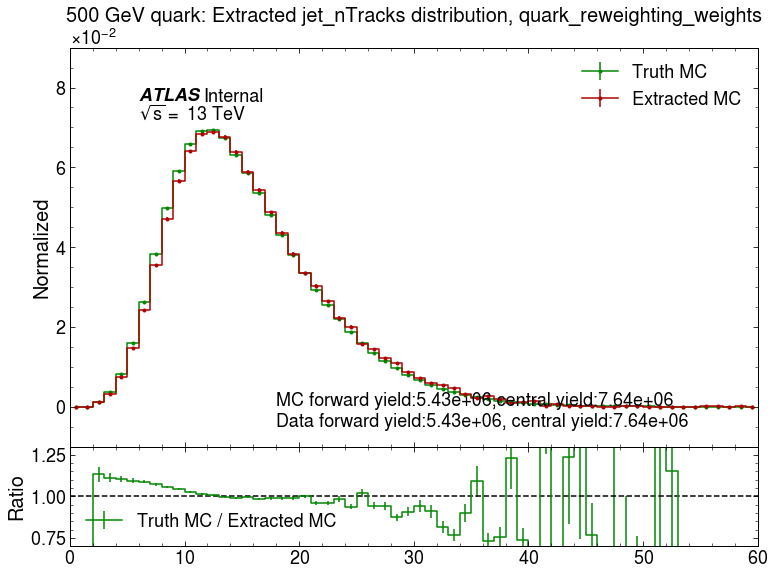

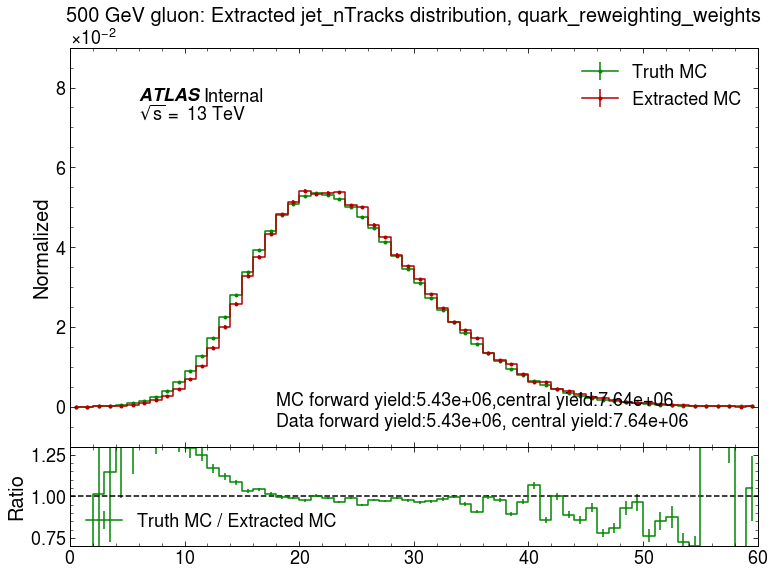

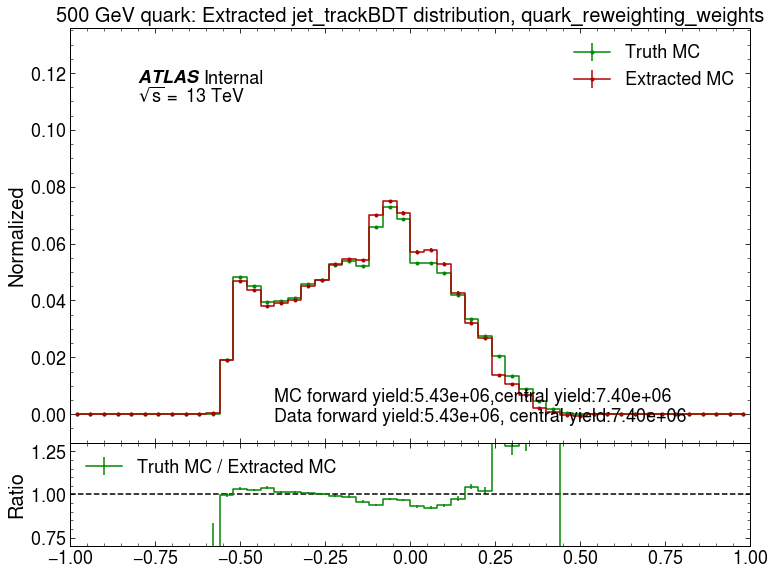

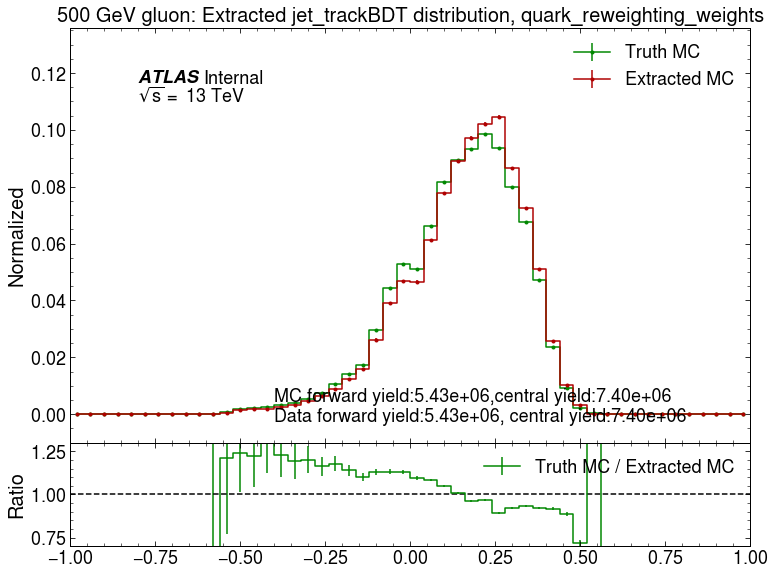

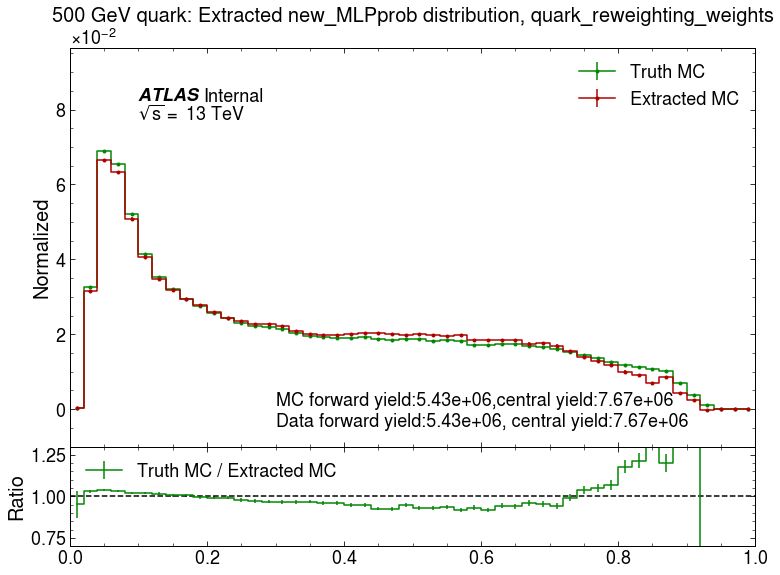

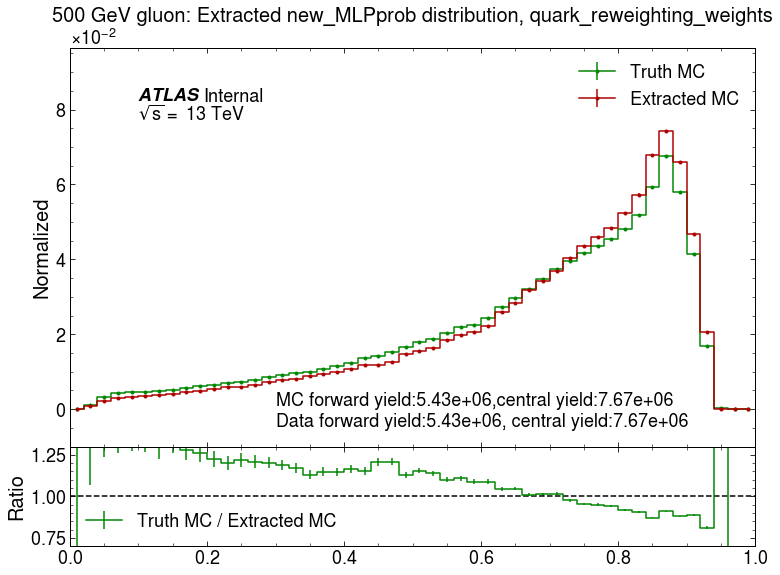

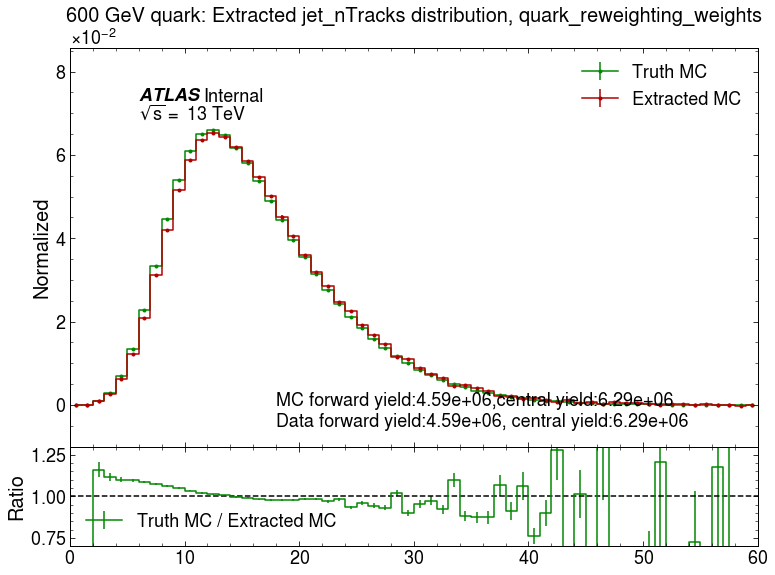

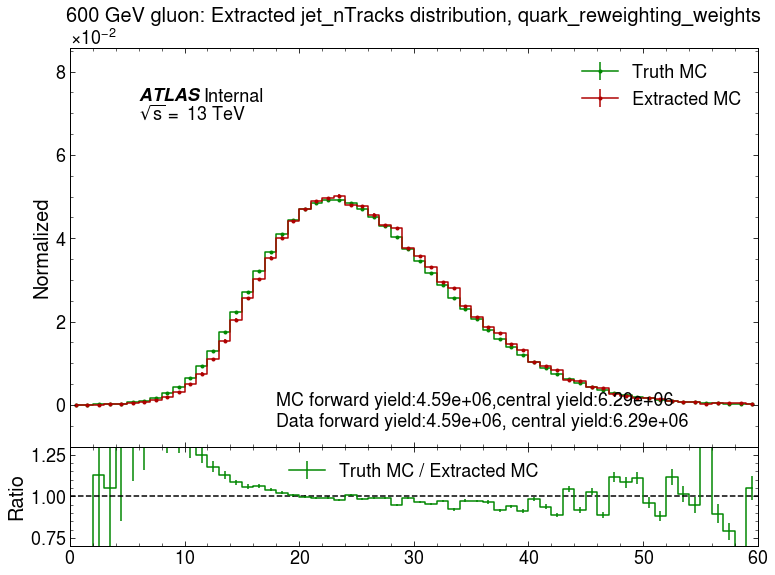

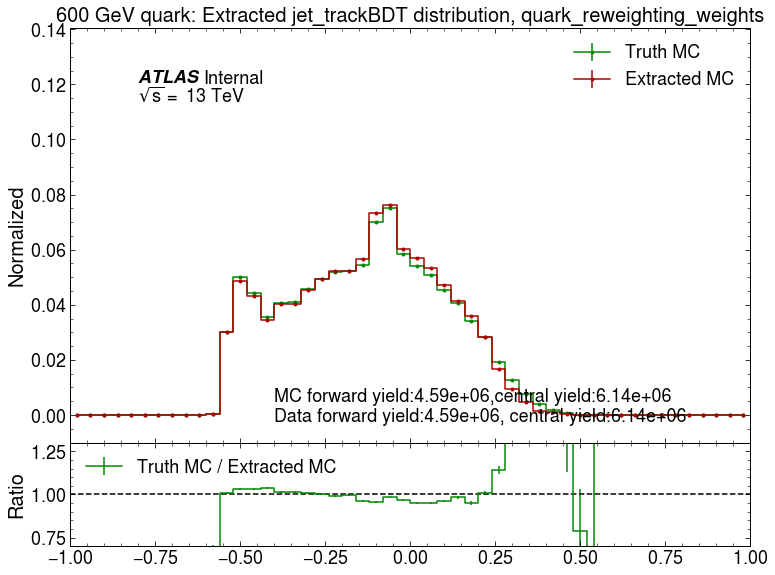

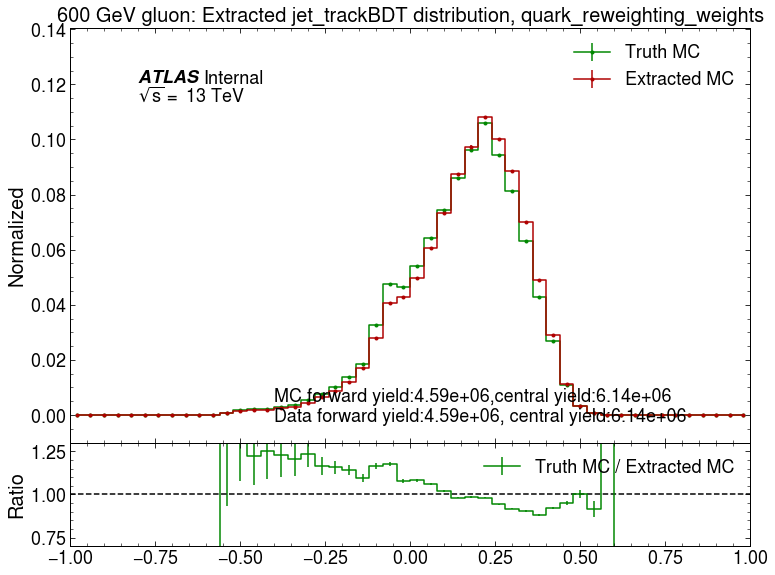

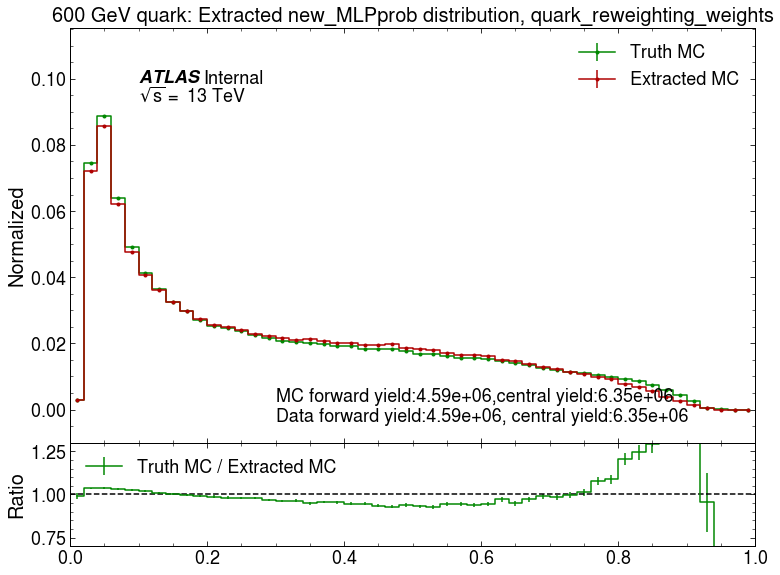

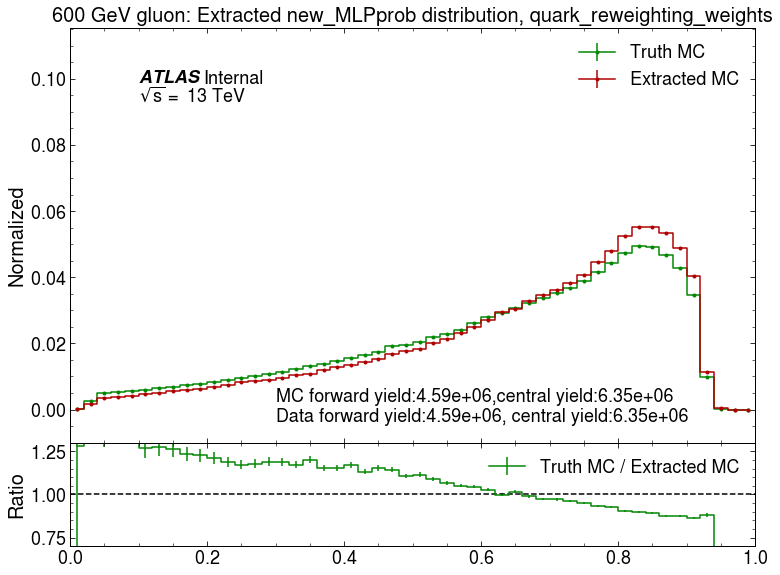

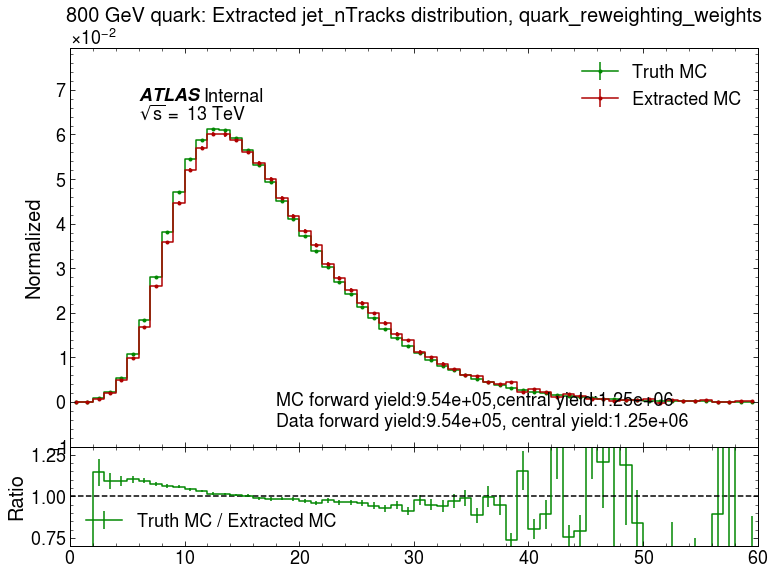

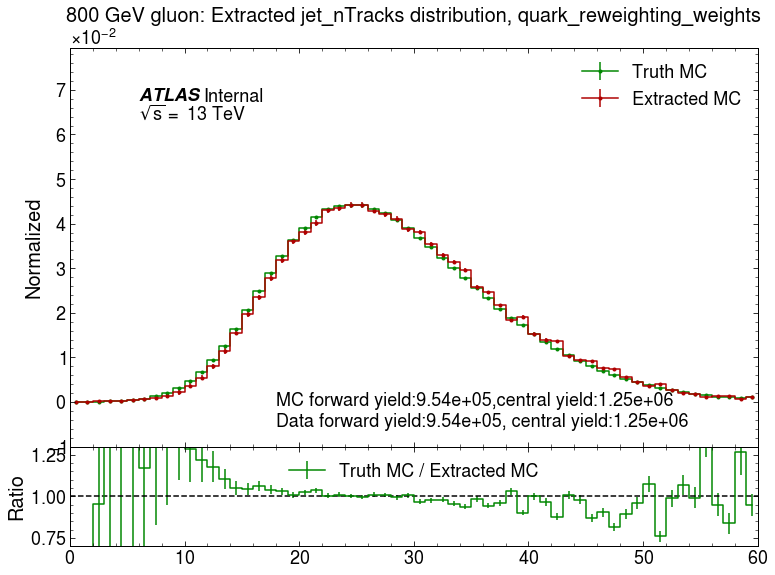

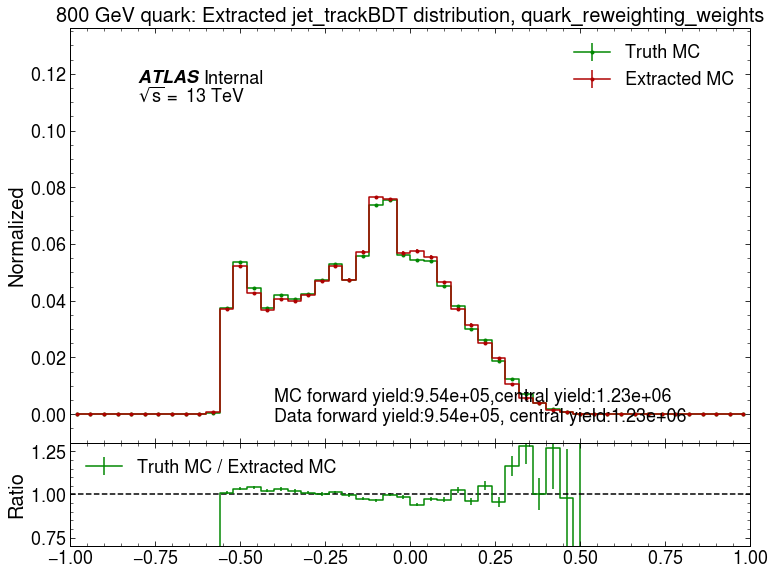

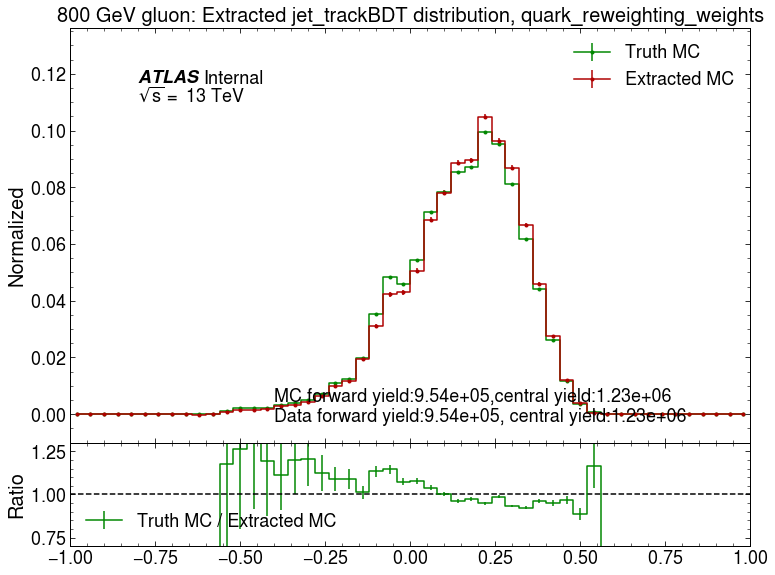

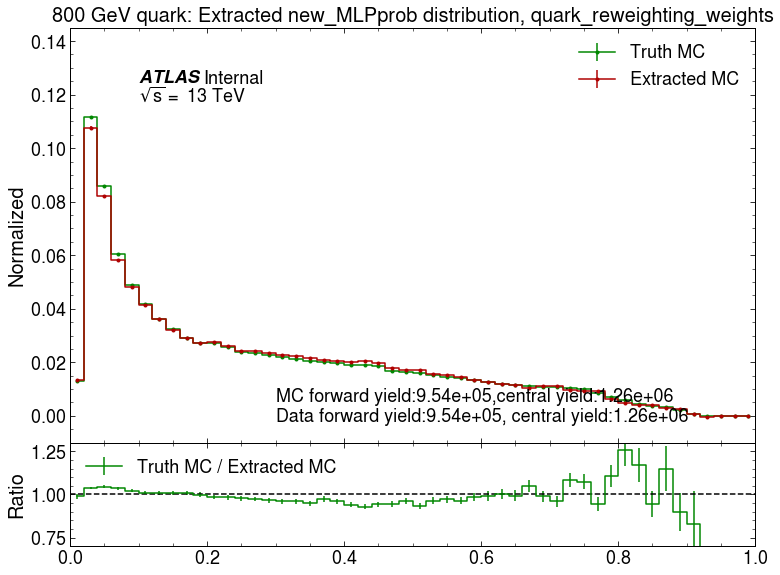

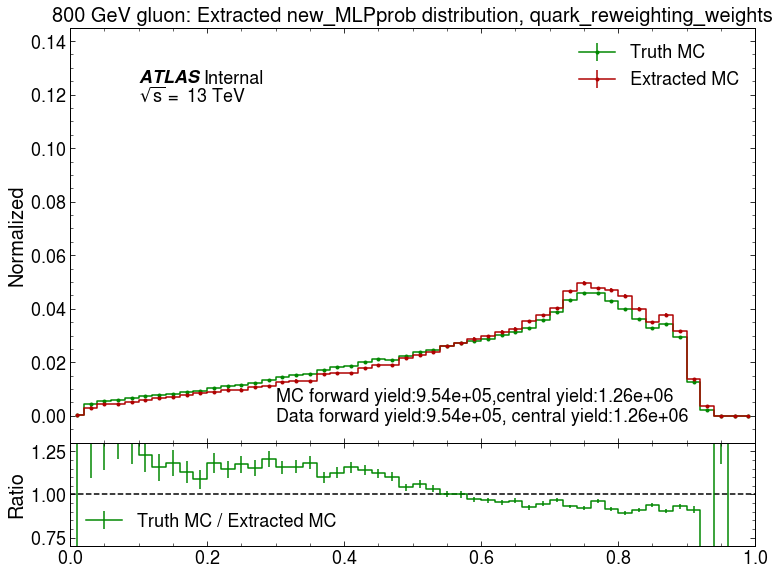

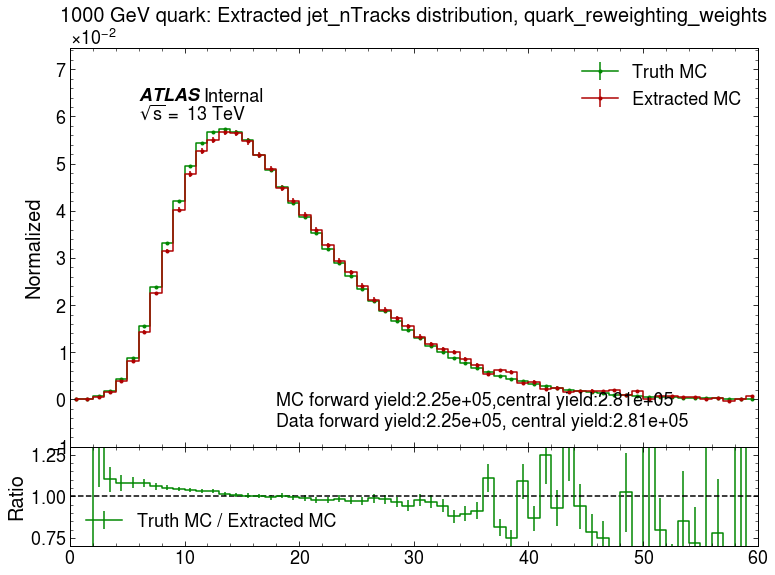

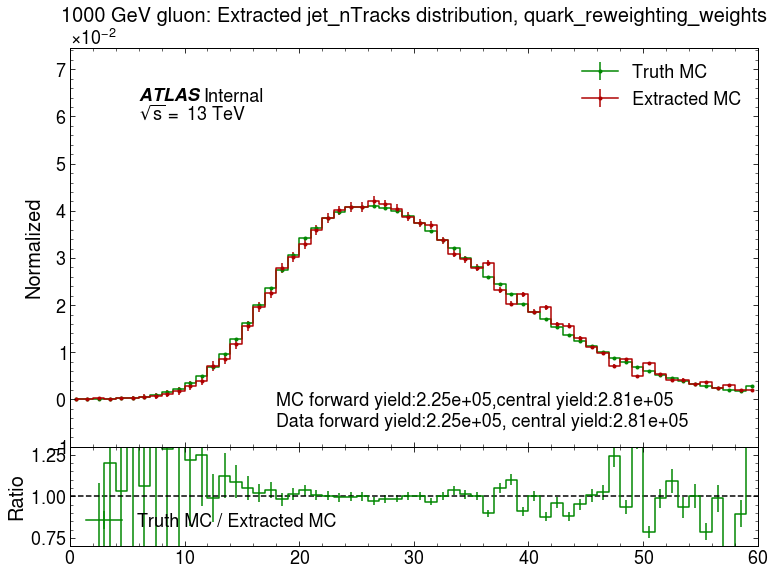

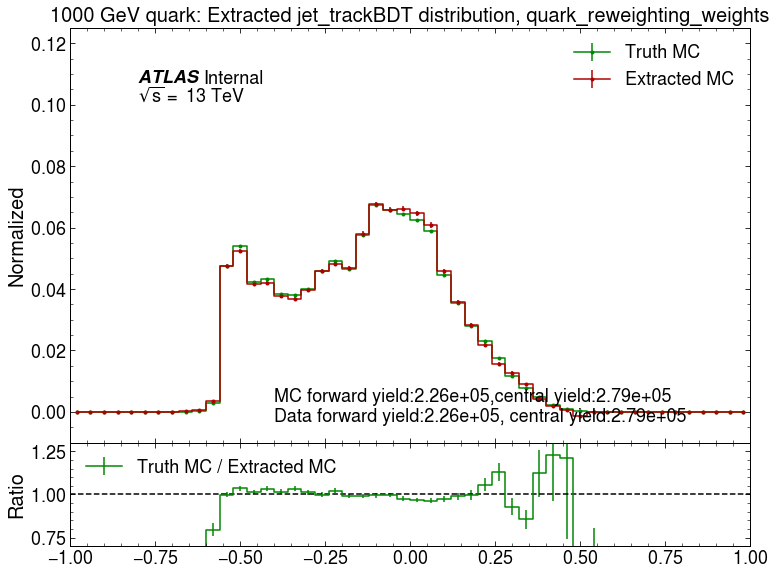

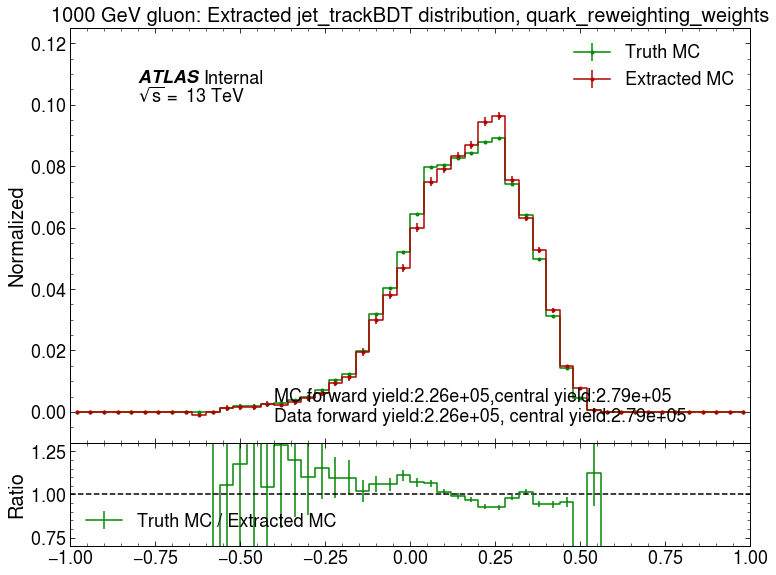

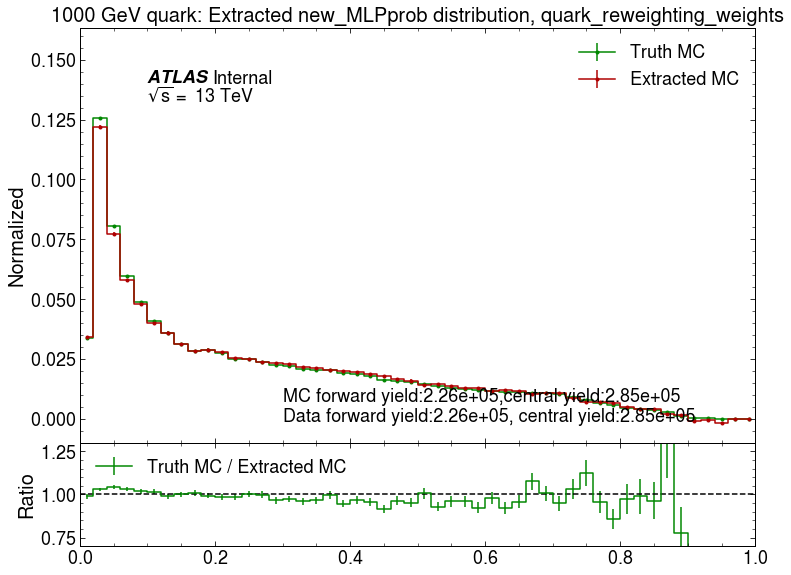

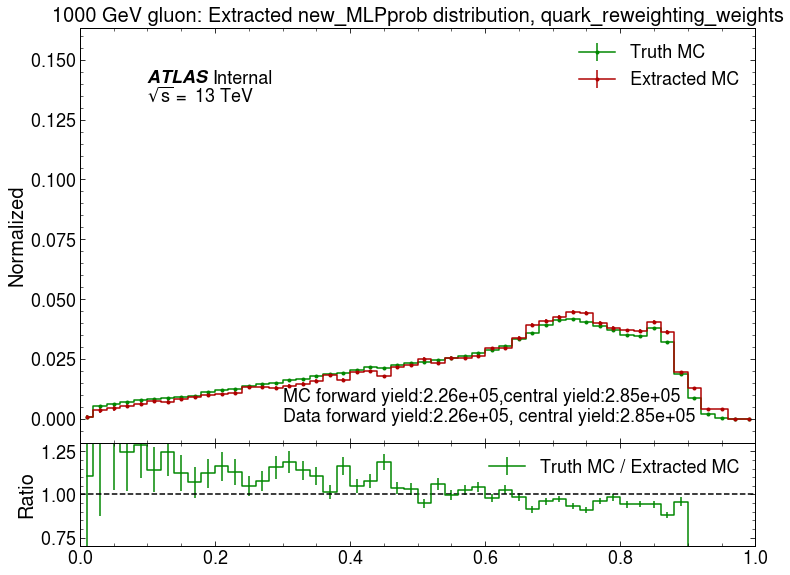

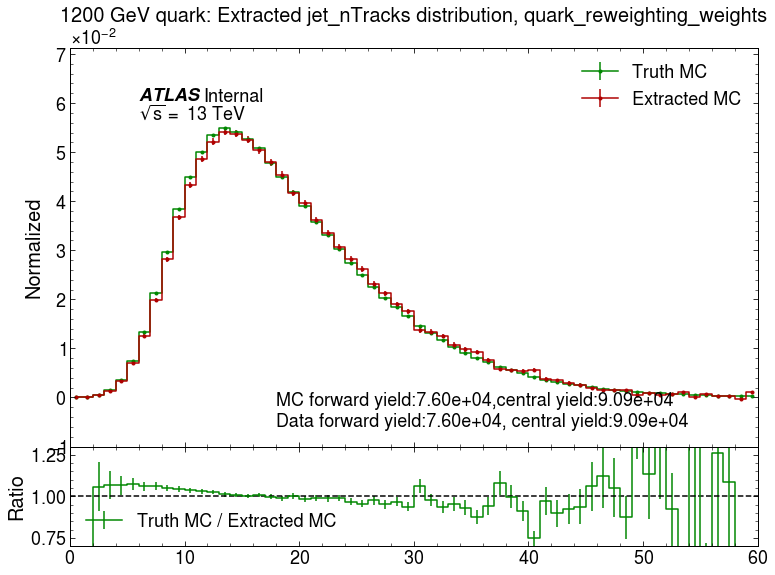

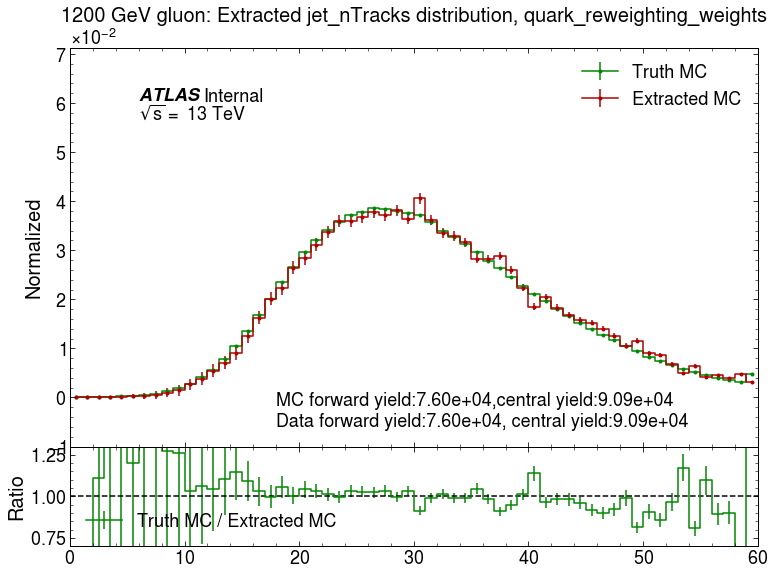

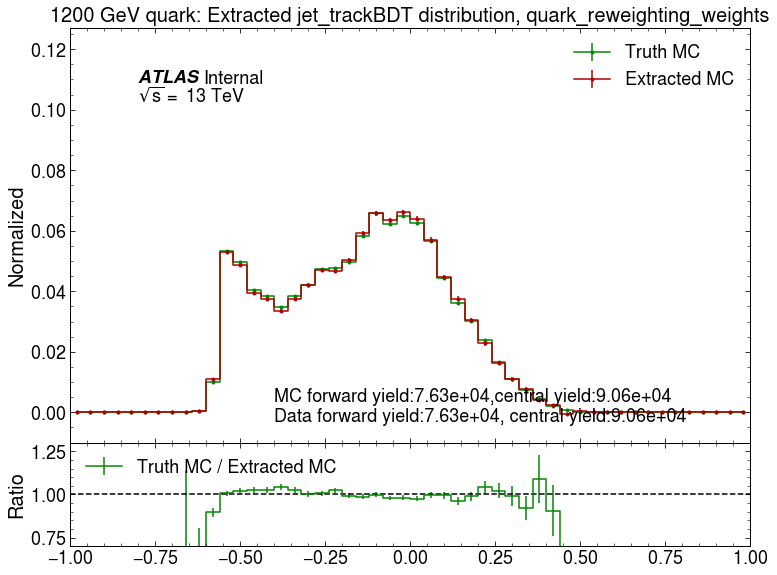

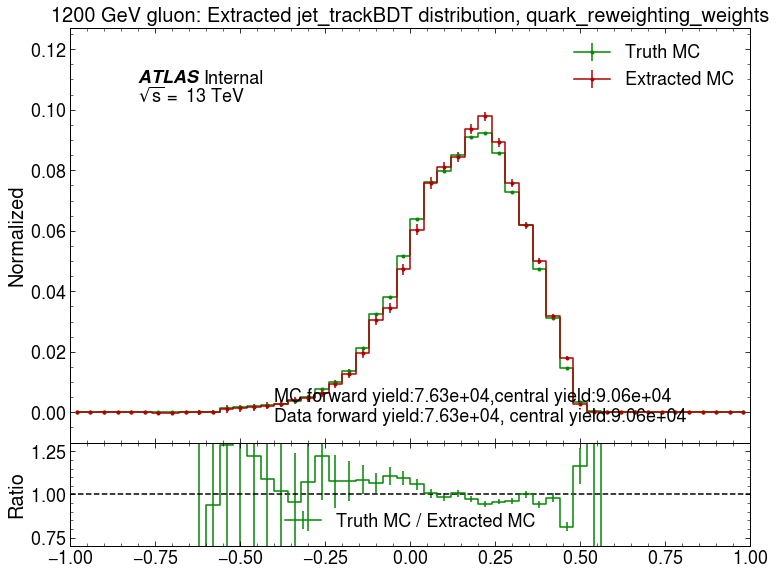

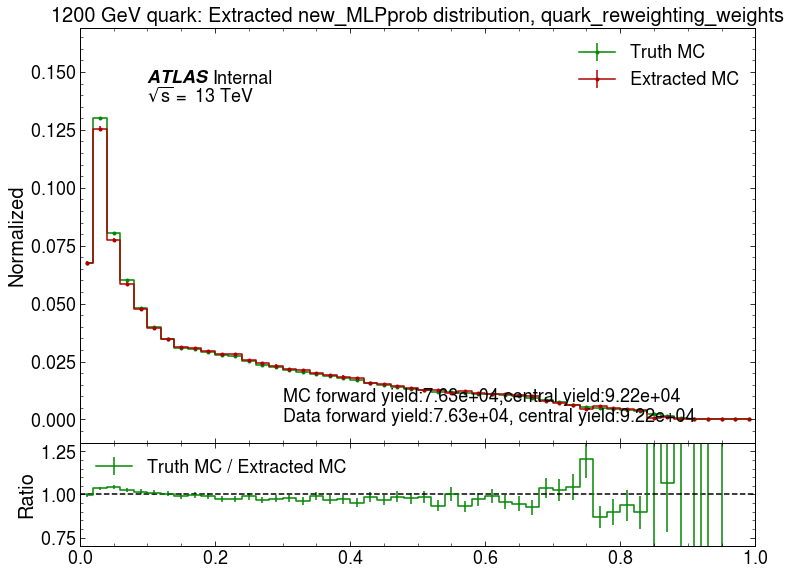

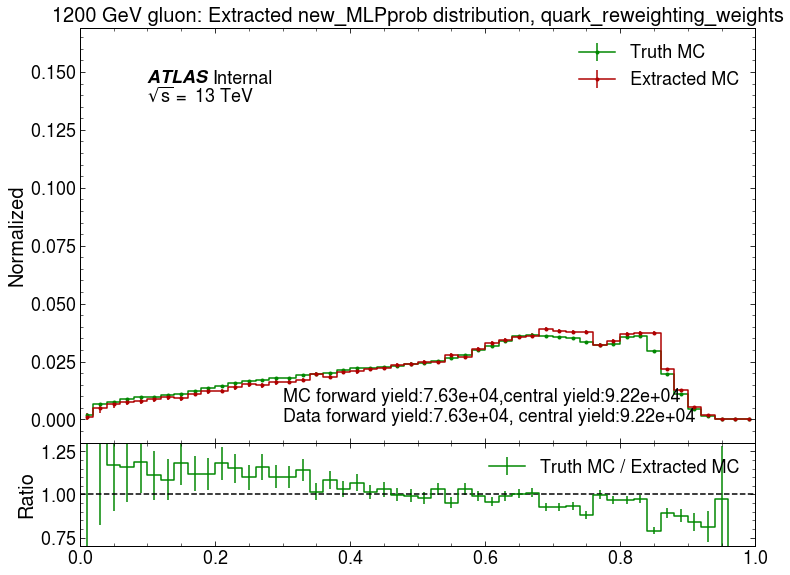

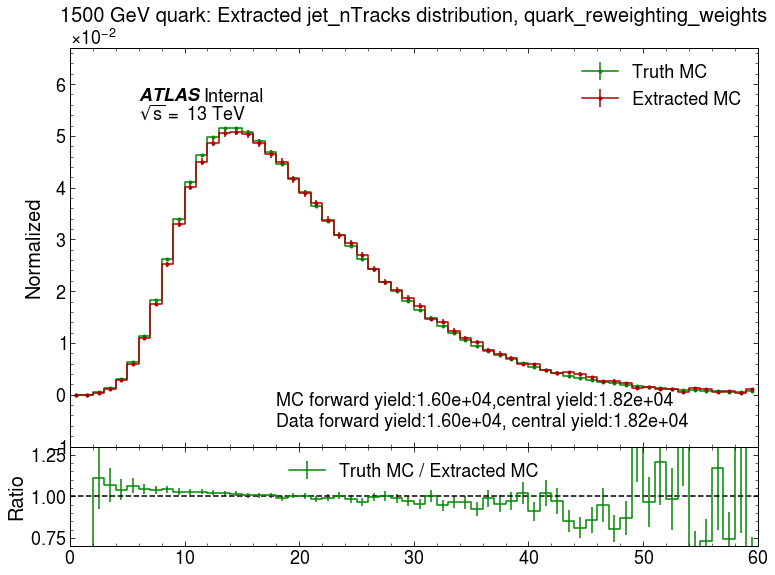

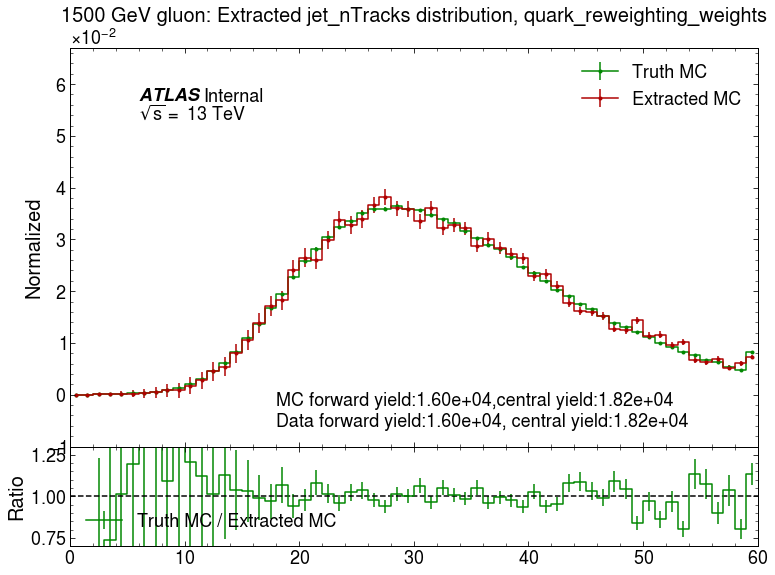

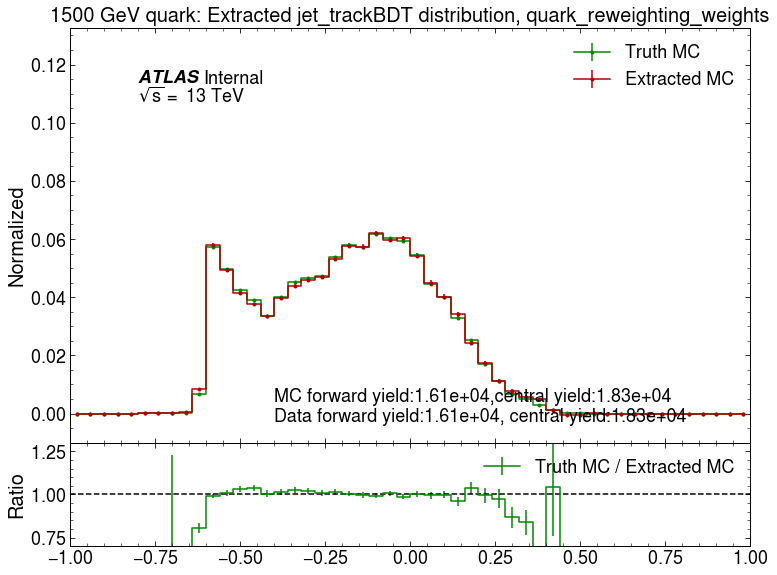

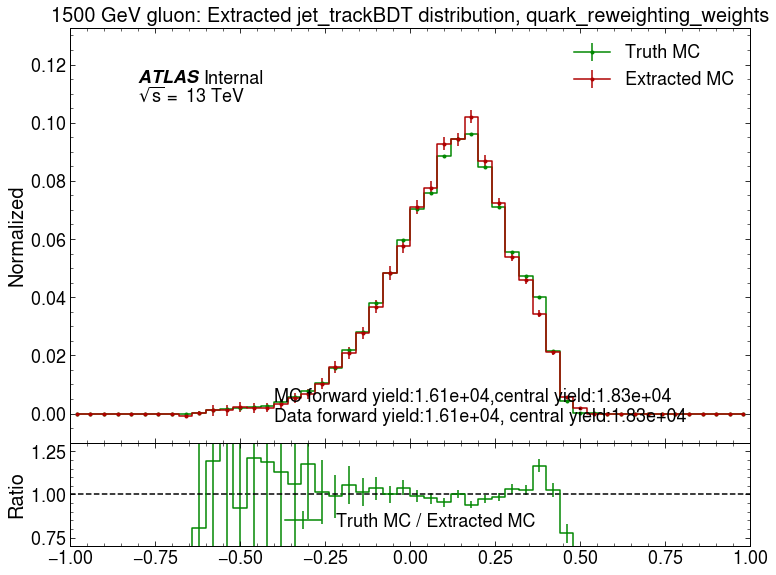

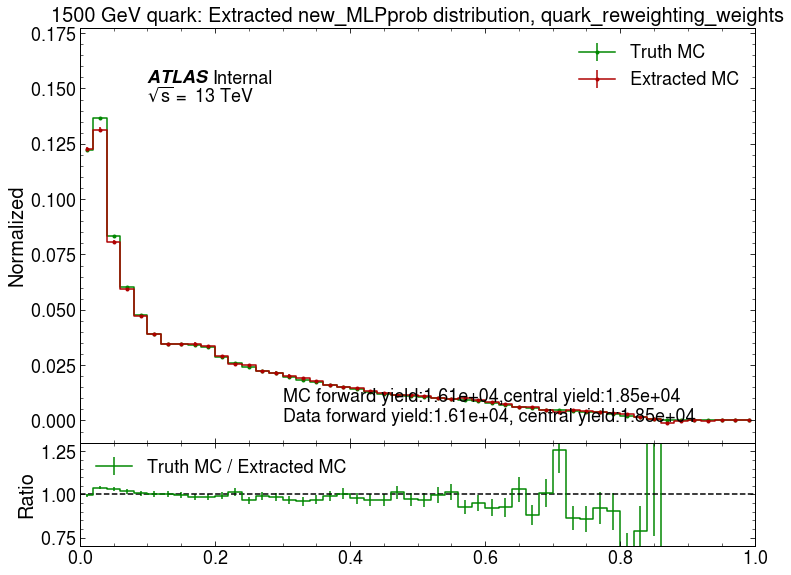

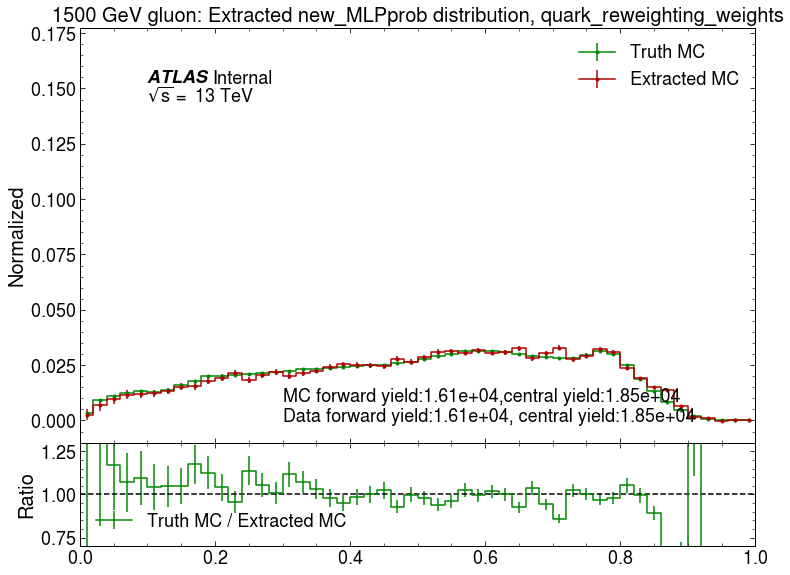

In [11]:
for l_pt in pt_list:
    for var in label_var:
        bin_var = HistBins[var] 
        for reweight in reweighting_list:
            Extraction_var_pt =  Extraction_Results[l_pt][var][reweight]
            
            #### Draw extraction plots 
            Plot_Extracted_unumpy(pt = l_pt, var= var, bin_edges = bin_var, output_path= Path('./'), 
                                    period= "A", reweighting_var = var,
                                    reweighting_factor= reweighting_map[reweight],
                                    p_Quark=Extraction_var_pt['p_Quark'], p_Gluon=Extraction_var_pt['p_Gluon'],
                                    extract_p_Quark = Extraction_var_pt['extract_p_Quark_MC'], extract_p_Gluon = Extraction_var_pt['extract_p_Gluon_MC'],
                                    extract_p_Quark_Data = Extraction_var_pt['extract_p_Quark_Data'], extract_p_Gluon_Data = Extraction_var_pt['extract_p_Gluon_Data'],
                                    show_yields=True, 
                                    n_Forward_MC = np.sum(unumpy.nominal_values(Extraction_var_pt['Forward_MC'])), 
                                    n_Central_MC = np.sum(unumpy.nominal_values(Extraction_var_pt['Central_MC'])), 
                                    n_Forward_Data = np.sum(unumpy.nominal_values(Extraction_var_pt['Forward_Data'])), 
                                    n_Central_Data = np.sum(unumpy.nominal_values(Extraction_var_pt['Central_Data'])))